In [68]:
import numpy as np
import pandas as pd
import zipfile
import pathlib
import os
import random

import tensorflow as tf
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [2]:
# Importing Dataset

# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-05-20 19:49:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109579078 (105M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.50M   122MB/s    in 0.9s    

2021-05-20 19:49:11 (122 MB/s) - ‘pizza_steak.zip.1’ saved [109579078/109579078]



In [3]:
TRAIN_PATH = "/content/pizza_steak/train/"
TEST_PATH = "/content/pizza_steak/test/"

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32

In [4]:
print(f"The training folders contain {len(os.listdir(TRAIN_PATH +'steak'))} steak images and {len(os.listdir(TRAIN_PATH +'pizza'))} pizza images")
print(f"The test folders contain {len(os.listdir(TEST_PATH +'steak'))} steak images and {len(os.listdir(TEST_PATH +'pizza'))} pizza images")

The training folders contain 750 steak images and 750 pizza images
The test folders contain 250 steak images and 250 pizza images


In [5]:
def view_random_image(target_dir, target_class):
  # Setup target directory 
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)
Image shape: (384, 512, 3)


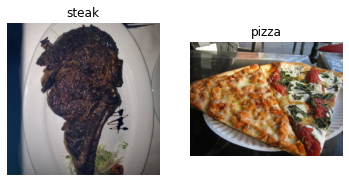

In [6]:
plt.figure()
plt.subplot(1, 2, 1)

steak = view_random_image(target_dir=TRAIN_PATH,
                        target_class="steak")

plt.subplot(1, 2, 2)

pizza = view_random_image(target_dir=TRAIN_PATH,
                        target_class="pizza")


In [7]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2, # rotate the image slightly
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

In [8]:
# Import data and augment it from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(TRAIN_PATH,
                                                                   target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                                   batch_size=BATCH_SIZE,
                                                                   class_mode='binary',
                                                                   shuffle=True) 

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(TEST_PATH,
                                             target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             batch_size=BATCH_SIZE,
                                             class_mode='binary')

Augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


In [9]:
IMG_TRAIN = TRAIN_PATH  + 'pizza/' + os.listdir(os.path.join(TRAIN_PATH, 'pizza/'))[0]

In [10]:
IMG_TRAIN

'/content/pizza_steak/train/pizza/829229.jpg'

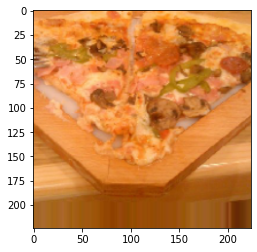

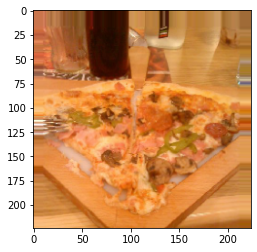

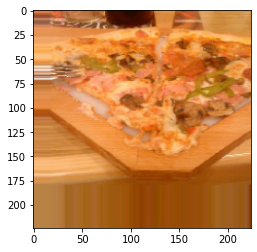

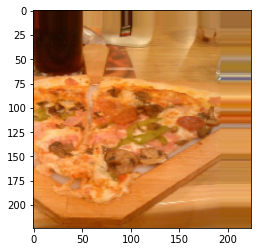

In [11]:
img = image.load_img(IMG_TRAIN, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
for batch in train_datagen_augmented.flow(x, batch_size=1):
  plt.figure(i)
  imgplot=plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%4==0:
    break

plt.show()

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [13]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

classifier = Sequential()

classifier.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=input_shape, activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))

classifier.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))

classifier.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))

classifier.add(Flatten())

classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(64, activation='relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(1, activation='sigmoid'))

classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [14]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0

In [15]:
history = classifier.fit(train_data_augmented, # changed to augmented training data
                        epochs=200,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                         callbacks=[myCallback()])

Epoch 1/200
47/47 [==============================] - 25s 444ms/step - loss: 0.7028 - accuracy: 0.5249 - val_loss: 0.6493 - val_accuracy: 0.5680
Epoch 2/200
47/47 [==============================] - 20s 434ms/step - loss: 0.6407 - accuracy: 0.6548 - val_loss: 0.5872 - val_accuracy: 0.7260
Epoch 3/200
47/47 [==============================] - 20s 436ms/step - loss: 0.6045 - accuracy: 0.6935 - val_loss: 0.4650 - val_accuracy: 0.8260
Epoch 4/200
47/47 [==============================] - 20s 427ms/step - loss: 0.5562 - accuracy: 0.7512 - val_loss: 0.4925 - val_accuracy: 0.8220
Epoch 5/200
47/47 [==============================] - 20s 430ms/step - loss: 0.5746 - accuracy: 0.7385 - val_loss: 0.3838 - val_accuracy: 0.8400
Epoch 6/200
47/47 [==============================] - 20s 432ms/step - loss: 0.5679 - accuracy: 0.7227 - val_loss: 0.4391 - val_accuracy: 0.8160
Epoch 7/200
47/47 [==============================] - 20s 429ms/step - loss: 0.5054 - accuracy: 0.7716 - val_loss: 0.4156 - val_accuracy:

In [16]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [17]:
loss, accuracy = classifier.evaluate(test_data, verbose=0)

print(f'The loss of the classifier is {loss}\n')
print(f'The accuracy of the classifier is {accuracy}')

The loss of the classifier is 0.21482644975185394

The accuracy of the classifier is 0.9139999747276306


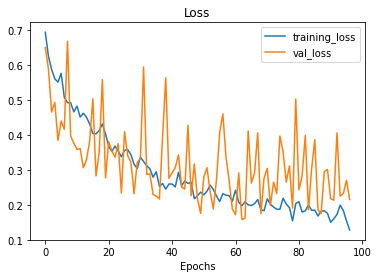

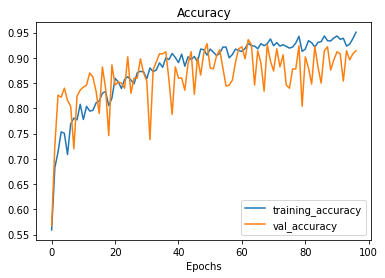

In [18]:
# Check out the loss curves of the classifier
plot_loss_curves(history)

In [ ]:
classifier.save('pizza_steak.h5')

In [20]:
# Create a function to import an image and resize it to be able to be used with our modle
def load_and_prep_image(filename, img_shape=224):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [26]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [60]:
from google.colab import files

uploaded = files.upload()

Saving k_archive_e3ce4eb1741bd76cc083424453c0e3f39d147f9b.jpg to k_archive_e3ce4eb1741bd76cc083424453c0e3f39d147f9b.jpg


In [61]:
steak = load_and_prep_image("k_archive_e3ce4eb1741bd76cc083424453c0e3f39d147f9b.jpg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.8476009 , 0.82799304, 0.81622833],
        [0.939357  , 0.91974914, 0.90798444],
        [0.88568676, 0.8660789 , 0.85039264],
        ...,
        [0.70245224, 0.67500126, 0.6357856 ],
        [0.70317936, 0.6757284 , 0.63651264],
        [0.6824175 , 0.65496653, 0.61575085]],

       [[0.8815761 , 0.8619683 , 0.8502036 ],
        [0.87608945, 0.8564816 , 0.8447169 ],
        [0.90334517, 0.88195163, 0.8755441 ],
        ...,
        [0.7407234 , 0.7132724 , 0.6740567 ],
        [0.72890383, 0.70145285, 0.66223717],
        [0.710723  , 0.683272  , 0.6440563 ]],

       [[0.9321147 , 0.9125069 , 0.9007422 ],
        [0.9034354 , 0.88382757, 0.8671115 ],
        [0.94294566, 0.9272594 , 0.9173854 ],
        ...,
        [0.7667375 , 0.7432081 , 0.6947141 ],
        [0.7242582 , 0.69288564, 0.6497484 ],
        [0.73701066, 0.7056381 , 0.66250086]],

       ...,

       [[0.909533  , 0.90561146, 0.8271801 ],
        [0.88

In [62]:
steak = tf.expand_dims(steak, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {steak.shape}")
steak

Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.8476009 , 0.82799304, 0.81622833],
         [0.939357  , 0.91974914, 0.90798444],
         [0.88568676, 0.8660789 , 0.85039264],
         ...,
         [0.70245224, 0.67500126, 0.6357856 ],
         [0.70317936, 0.6757284 , 0.63651264],
         [0.6824175 , 0.65496653, 0.61575085]],

        [[0.8815761 , 0.8619683 , 0.8502036 ],
         [0.87608945, 0.8564816 , 0.8447169 ],
         [0.90334517, 0.88195163, 0.8755441 ],
         ...,
         [0.7407234 , 0.7132724 , 0.6740567 ],
         [0.72890383, 0.70145285, 0.66223717],
         [0.710723  , 0.683272  , 0.6440563 ]],

        [[0.9321147 , 0.9125069 , 0.9007422 ],
         [0.9034354 , 0.88382757, 0.8671115 ],
         [0.94294566, 0.9272594 , 0.9173854 ],
         ...,
         [0.7667375 , 0.7432081 , 0.6947141 ],
         [0.7242582 , 0.69288564, 0.6497484 ],
         [0.73701066, 0.7056381 , 0.66250086]],

        ...,

        [[0.909533  , 0.90561146, 

In [63]:
# Make a prediction on custom image tensor
proba = classifier.predict(steak)
proba

array([[0.9999857]], dtype=float32)

In [64]:
data_dir = pathlib.Path("pizza_steak/train/") # turn training path into a Python path

class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
class_names = class_names[1:]

In [65]:
pred_class = class_names[int(tf.round(proba)[0][0])]
pred_class

'steak'

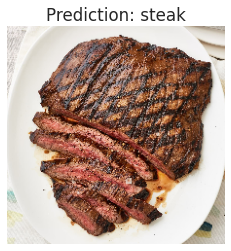

In [66]:
# Make a prediction using classifier
pred_and_plot(classifier, 
              filename="k_archive_e3ce4eb1741bd76cc083424453c0e3f39d147f9b.jpg", 
              class_names=class_names)

In [28]:
from google.colab import files

uploaded = files.upload()

Saving Eq_it-na_pizza-margherita_sep2005_sml.jpg to Eq_it-na_pizza-margherita_sep2005_sml.jpg


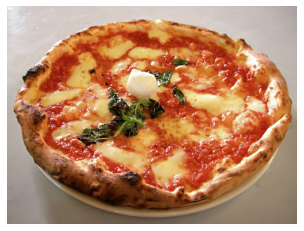

In [29]:
pizza = mpimg.imread("Eq_it-na_pizza-margherita_sep2005_sml.jpg")
plt.imshow(pizza)
plt.axis(False);

In [30]:
pizza = load_and_prep_image("Eq_it-na_pizza-margherita_sep2005_sml.jpg")
pizza

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.93417364, 0.9380952 , 0.94593835],
        [0.93447375, 0.9383953 , 0.94623846],
        [0.9088035 , 0.9127251 , 0.9205682 ],
        ...,
        [0.67294925, 0.64443773, 0.62408996],
        [0.67142856, 0.640056  , 0.6282913 ],
        [0.66648626, 0.6351137 , 0.623349  ]],

       [[0.8769908 , 0.89267707, 0.9022409 ],
        [0.91484594, 0.9196679 , 0.9248099 ],
        [0.9537015 , 0.9601441 , 0.9604242 ],
        ...,
        [0.67565024, 0.6442777 , 0.632513  ],
        [0.66464573, 0.6332732 , 0.6215085 ],
        [0.6599239 , 0.62855136, 0.61678666]],

       [[0.92424977, 0.92817134, 0.9360145 ],
        [0.9976591 , 0.9976591 , 0.9976591 ],
        [0.9997199 , 1.        , 0.9927171 ],
        ...,
        [0.6666466 , 0.63527405, 0.62350935],
        [0.6664866 , 0.6351141 , 0.62334937],
        [0.6611239 , 0.6297513 , 0.6179866 ]],

       ...,

       [[0.5269506 , 0.49081618, 0.45552206],
        [0.54

In [31]:
pizza = tf.expand_dims(pizza, axis=0) # add an extra dimension at axis 0
print(f"Shape after new dimension: {pizza.shape}")
pizza

Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.93417364, 0.9380952 , 0.94593835],
         [0.93447375, 0.9383953 , 0.94623846],
         [0.9088035 , 0.9127251 , 0.9205682 ],
         ...,
         [0.67294925, 0.64443773, 0.62408996],
         [0.67142856, 0.640056  , 0.6282913 ],
         [0.66648626, 0.6351137 , 0.623349  ]],

        [[0.8769908 , 0.89267707, 0.9022409 ],
         [0.91484594, 0.9196679 , 0.9248099 ],
         [0.9537015 , 0.9601441 , 0.9604242 ],
         ...,
         [0.67565024, 0.6442777 , 0.632513  ],
         [0.66464573, 0.6332732 , 0.6215085 ],
         [0.6599239 , 0.62855136, 0.61678666]],

        [[0.92424977, 0.92817134, 0.9360145 ],
         [0.9976591 , 0.9976591 , 0.9976591 ],
         [0.9997199 , 1.        , 0.9927171 ],
         ...,
         [0.6666466 , 0.63527405, 0.62350935],
         [0.6664866 , 0.6351141 , 0.62334937],
         [0.6611239 , 0.6297513 , 0.6179866 ]],

        ...,

        [[0.5269506 , 0.49081618, 

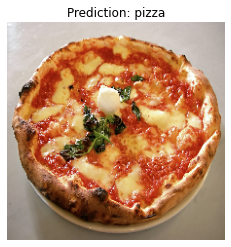

In [32]:
# Make a prediction using classifier
pred_and_plot(classifier, 
              filename="Eq_it-na_pizza-margherita_sep2005_sml.jpg", 
              class_names=class_names)

In [48]:
import pickle

predictions = classifier.predict(test_data, len(test_data))

pickle_out = open("predictions.pickle","wb")
pickle.dump(predictions, pickle_out)
pickle_out.close()

In [55]:
pickle_in = open("predictions.pickle","rb")
predictions = pickle.load(pickle_in)

bad_predicted_pizza = []
#bad_predicted_steak = []
good_predicted_pizza = []
#good_predicted_steak = []

for index, probability in enumerate(predictions):
    image_path = TEST_PATH + "/" + test_data.filenames[index]
    img = mpimg.imread(image_path)

    actually_pizza = "pizza" in image_path

    predicted_pizza = False
    if probability < 0.5:
        predicted_pizza = True

    if actually_pizza and not predicted_pizza:
        # pizza predicted as a steak
        bad_predicted_pizza.append([img, probability])

    if actually_pizza and predicted_pizza:
        # pizza predicted as a pizza
        good_predicted_pizza.append([img, probability])

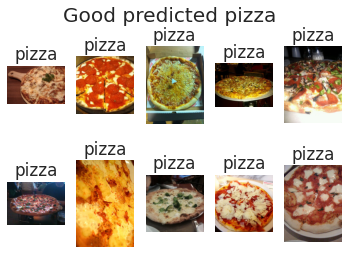

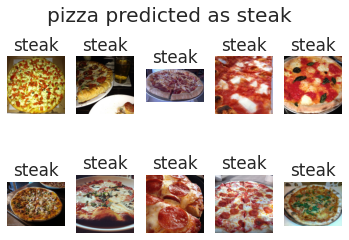

In [56]:
n_images = 10

# Good predicted pizza
fig = plt.figure()
fig.suptitle("Good predicted pizza")
for i in range(n_images):
    index = i
    img = good_predicted_pizza[index][0]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title('pizza')
    ax.axis("off")
    ax.imshow(img)

plt.show()
plt.close()

# Print incorrect predicted pizza images
fig = plt.figure()
fig.suptitle("pizza predicted as steak")
for i in range(n_images):
    index = i + 30
    img = bad_predicted_pizza[index][0]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title('steak')
    ax.imshow(img)
    ax.axis("off")

plt.show()
plt.close()

Found 500 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


16/16 [==============================] - 2s 131ms/step


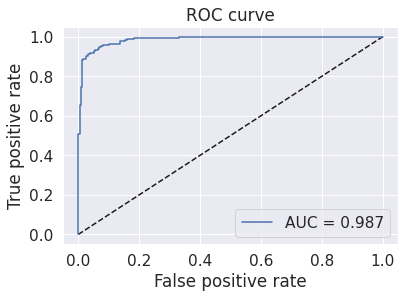

In [69]:
roc_val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(TEST_PATH,
                                                                                  target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                                                  batch_size=BATCH_SIZE,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
predictions = classifier.predict_generator(roc_val_generator, steps=len(roc_val_generator), verbose=1)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_val_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()